In [227]:
import os
import tensorflow as tf
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Input, Cropping2D
from keras.models import Model
from keras.optimizers import Adam
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from skimage.io import imread
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

## 1. Read images

In [228]:
TRAIN_IMG_PATH = 'banco_dados_SB/train/imagens/'
TRAIN_LBL_PATH = 'banco_dados_SB/train/classes/'

TEST_IMG_PATH = 'banco_dados_SB/test/imagens/'
TEST_LBL_PATH = 'banco_dados_SB/test/classes/'

In [229]:
X_train = [imread(fname=TRAIN_IMG_PATH + img, as_grey=True) for img in os.listdir(TRAIN_IMG_PATH)]
y_train = [imread(fname=TRAIN_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TRAIN_LBL_PATH)]
X_test = [imread(fname=TEST_IMG_PATH + img, as_grey=True) for img in os.listdir(TEST_IMG_PATH)]
y_test = [imread(fname=TEST_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TEST_LBL_PATH)]

## 2. Prepare Data

In [230]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
mean = np.mean (X_train) # tirando a media das imagens de treinamento
std = np.std (X_train) # normalizando a imagem de treinamento
X_train -= mean
X_train /= std

In [231]:
# preparando X_test, verificar que se usa a mesma media e desvio padrão obtidos com as imagens de treinamento
X_test = np.asarray(X_test)
y_test = np.asarray (y_test)
X_test -= mean
X_test /= std

In [232]:
print ('X_train shape = {0} and y_train shape = {1} '.format (X_train.shape ,y_train.shape))
print ('X_test shape  = {0}  and y_test shape  = {1} '.format (X_test.shape ,y_test.shape))

X_train shape = (338, 256, 256) and y_train shape = (338, 256, 256) 
X_test shape  = (82, 256, 256)  and y_test shape  = (82, 256, 256) 


## 3. Definindo função Dice

In [233]:
# função Dice para utilizar nas métricas
smooth = 1.
K.set_image_data_format('channels_last')
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


## 4. Dividindo as amostras entre conjunto de treino e validation

In [234]:
print ('Maior numero label train: ',np.max(y_train))
print ('Menor numero label train: ',np.min(y_train))

Maior numero label train:  2
Menor numero label train:  0


In [235]:
bounds = int(len(X_train)-(np.floor(338*.1)))
print (bounds)
X_validate = X_train[bounds:,:,:]
y_validate = y_train[bounds:,:,:]
X_train = X_train[:bounds,:,:]
y_train = y_train[:bounds,:,:]
print(X_validate.shape,y_validate.shape )
print(X_train.shape,y_train.shape )
print ('Maior numero label train: ',np.max(y_train))
print ('Menor numero label train: ',np.min(y_train))

305
(33, 256, 256) (33, 256, 256)
(305, 256, 256) (305, 256, 256)
Maior numero label train:  2
Menor numero label train:  0


## 5. Testing data set

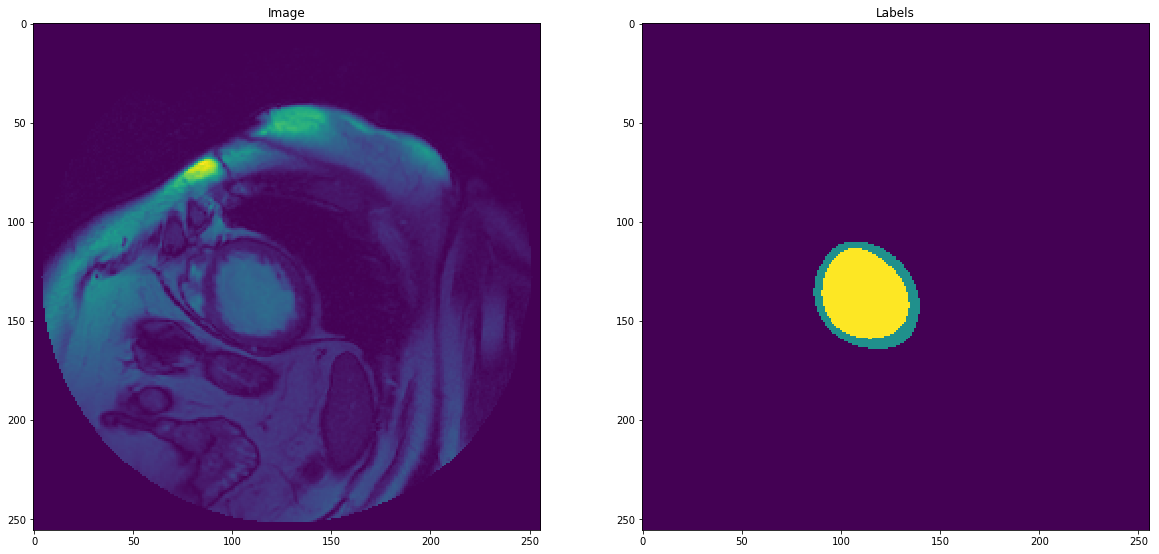

In [236]:
idx = 145

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[idx])
ax[0].set_title('Image')

ax[1].imshow(y_train[idx])
ax[1].set_title('Labels')

plt.show()

## 6. Create CNN model

In [237]:
class Unet_LIS(object):

    def __init__(self, img_rows , img_cols):
        self.img_rows = img_rows
        self.img_cols = img_cols
            
    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(conv9)
        model = Model(input = inputs, output = conv10)

        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coef])

        return model

In [238]:
myunet = Unet_LIS(X_train[0].shape[0],X_train[0].shape[1])
model = myunet.get_unet()

C:\Users\Tales\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [239]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_185 (Conv2D)              (None, 256, 256, 64)  640         input_9[0][0]                    
____________________________________________________________________________________________________
conv2d_186 (Conv2D)              (None, 256, 256, 64)  36928       conv2d_185[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D)  (None, 128, 128, 64)  0           conv2d_186[0][0]                 
___________________________________________________________________________________________

## 7. Prepare data

In [240]:
# Reshape input images to fit TensorFlow shape pattern
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], 1)
y_validate = y_validate.reshape(y_validate.shape[0], y_validate.shape[1], y_validate.shape[2], 1)

## 8. Train model

In [241]:
from keras.models import load_model
savings = "./savings_UNet3L_ZM_1"
if os.path.isdir(savings):
    path_sav = "savings_UNet3L_ZM_1/"
    model.load_weights(path_sav +'U_net_ZM_1.h5')
    print('Rede iniciando de onde parou')

Rede iniciando de onde parou


In [242]:
batch_size = 16
epochs = 15
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_3L', histogram_freq=0,  
          write_graph=True, write_images=True,batch_size=batch_size)

# Monitorando se a função não esta aprendendo mais...
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_validate, y_validate),
          callbacks=[tbCallBack,early_stopping])

Train on 305 samples, validate on 33 samples
Epoch 1/15
305/305 [==============================] - 1554s - loss: -0.1030 - dice_coef: 0.9427 - val_loss: 0.3444 - val_dice_coef: 0.6280
Epoch 2/15
305/305 [==============================] - 1554s - loss: -0.2457 - dice_coef: 1.0493 - val_loss: -0.0875 - val_dice_coef: 0.8802
Epoch 3/15
305/305 [==============================] - 1557s - loss: -0.2696 - dice_coef: 1.1245 - val_loss: -0.0862 - val_dice_coef: 0.9120
Epoch 4/15
305/305 [==============================] - 1551s - loss: -0.2792 - dice_coef: 1.1280 - val_loss: -0.1274 - val_dice_coef: 0.9626
Epoch 5/15
305/305 [==============================] - 1567s - loss: -0.2867 - dice_coef: 1.1555 - val_loss: -0.1487 - val_dice_coef: 1.0008
Epoch 6/15
305/305 [==============================] - 1564s - loss: -0.2897 - dice_coef: 1.1637 - val_loss: -0.1641 - val_dice_coef: 1.0296
Epoch 7/15
305/305 [==============================] - 1562s - loss: -0.2922 - dice_coef: 1.1690 - val_loss: -0.1883 

In [243]:
if not os.path.isdir('savings_UNet3L_ZM_1'):
    path_sav = "savings_UNet3L_ZM_1/"
    os.makedirs(path_sav)
model.save_weights(path_sav +'U_net_ZM_1.h5')

In [244]:
P_fig = model.predict(X_test, batch_size=batch_size, verbose=1)

82/82 [==============================] - 134s   


## 9. Transformando para valores inteiros imagem teste predict

In [245]:
#  Ao converter de valores float para inteiros vc tem o valor final da imagem aproximado
# como se fosse o valor mais proximo daquele número previsto
P_fig.shape
im_final = P_fig.astype ('uint8')
im_teste= np.round(P_fig).astype('uint8')
im_final = np.squeeze(im_final)
im_teste = np.squeeze(im_teste)
print('Maximo número im_teste: ',np.max(im_teste)) # arredondado pelo np.round
print('Maximo número im_final: ',np.max(im_final)) # arredondado diretamente por .astype('uint8')
im_final.shape

Maximo número im_teste:  1
Maximo número im_final:  1


(82, 256, 256)

Text(0.5,1,'Imagem final')

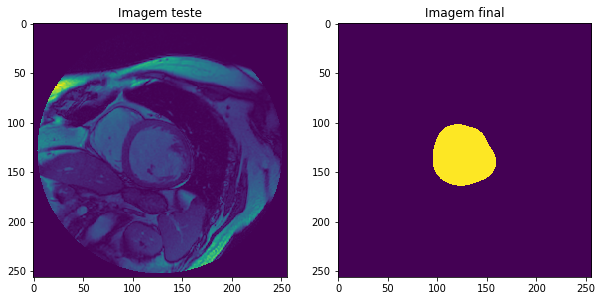

In [290]:
idx = 35

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_test[idx,:,:,0])
ax[0].set_title('Imagem teste')

ax[1].imshow(im_final[idx,:,:])
ax[1].set_title('Imagem final')

In [247]:
sess = tf.Session()
writer = tf.summary.FileWriter("Graph_3L_ZM_1")
writer.add_graph (sess.graph)
sess.close()